PyGeNN Tutorial: Ring of neurons
===========================

Load some standard libraries and the needed elements of PyGeNN
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pygenn.genn_model import (GeNNModel, init_connectivity, create_cmlf_class,
                               create_custom_sparse_connect_init_snippet_class)
from pygenn.genn_wrapper import NO_DELAY

Create the model class and set the time step
---

In [2]:
model = GeNNModel("float", "LIFRing")
model.dT = 0.1

Define an initialisation code snippet
---

In [3]:
ring_model = create_custom_sparse_connect_init_snippet_class(
    "ring",
    row_build_code=
        """
        $(addSynapse, ($(id_pre) + 1) % $(num_post));
        $(endRow);
        """,
    calc_max_row_len_func=create_cmlf_class(
        lambda num_pre, num_post, pars: 1)())

Define some neuron parameters and initial variables
---

In [4]:
N = 10
p = {"C": 1.0,       # Membrane capacitance [nF]
    "TauM": 10.0,     # Membrane time constant [ms]
    "Vrest": 0.0,    # Resting membrane potential [mV]
    "Vreset": -1.0,  # Reset voltage [mV]
    "Vthresh": 1.0,  # Spiking threshold [mV]
    "Ioffset": 0.0,  # Offset current [nA]
    "TauRefrac": 1.0 # Refractory period [ms]
    }

ini= {"V": 0.0,      # Membrane potential [mV]
     "RefracTime": 0.0 # Remaining refractory time [ms]
     }

stim_ini = {"startSpike": [0], "endSpike": [1]}

Define some synaptic parameters and initial values
---

In [5]:
s_ini = {"g": 0.05}

ps_p = {"tau": 5.0,  # Decay time constant [ms] 
        "E": 10.0}  # Reversal potential [mV]

Add a neuron population and stimulus population
---

In [6]:
pop1 = model.add_neuron_population("Pop1", N, "LIF", p, ini)
stim = model.add_neuron_population("Stim", 1, "SpikeSourceArray", {}, stim_ini)

Add a synapse population: 
---
Connect the LIF neurons in a ring with the "ring" init snippet


In [7]:
syn1 = model.add_synapse_population("Pop1self", "SPARSE_GLOBALG", 10,
    pop1, pop1,
    "StaticPulse", {}, s_ini, {}, {},
    "ExpCond", ps_p, {},
    init_connectivity(ring_model, {}))

Add a second synapse population: 
---
Connect the stimuli to the neurons

In [8]:
model.add_synapse_population("StimPop1", "SPARSE_GLOBALG", NO_DELAY,
    stim, pop1,
    "StaticPulse", {}, s_ini, {}, {},
    "ExpCond", ps_p, {},
    init_connectivity("OneToOne", {}))

Initialize the spike source array
---

In [9]:
stim.set_extra_global_param("spikeTimes", [0.0])

Build the model
---
This step does the entire code generation and C++/CUDA compilation!

In [10]:
m = model.build()

Load the model
---
This step will initialize the model

In [11]:
model.load()

Run the model for some time steps
---

In [12]:
v = np.empty((2000, N))
v_view = pop1.vars["V"].view
while model.t < 200.0:
    model.step_time()
    pop1.pull_var_from_device("V")
    
    v[model.timestep - 1,:]=v_view[:]

Plot the results
---

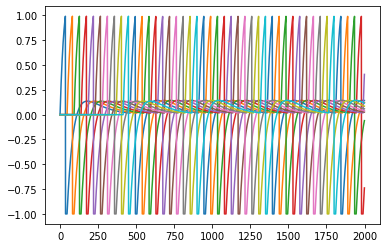

In [13]:
fig, axis = plt.subplots()
axis.plot(v[:,:])
#plt.xlim((0,250))
plt.show()